# IBM Streams sample application

This sample demonstrates creating a Streams Python application to perform some analysis of streaming data and view the results.

Familiarity with [Python](https://www.python.org/about/gettingstarted/) is recommended.


In this notebook, you'll see examples of how to:
 1. [Setup a connection to the Streams instance](#setup)
 2. [Create the application](#create)
 3. [Submit the application](#launch)
 4. [Connect to the running application to view data](#view)
 5. [Stop the application](#cancel)

# Overview

**About the sample**

This application simulates a data hub that receives readings from sensors. It computes the 30 second rolling average of the reported readings using [Pandas](https://pandas.pydata.org/).  

**How it works**
   
A Streams Python application processes a continuous and potentially infinite stream of data. The data is processed in memory and is not stored in a database first.

The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to continuously retrieve the results.

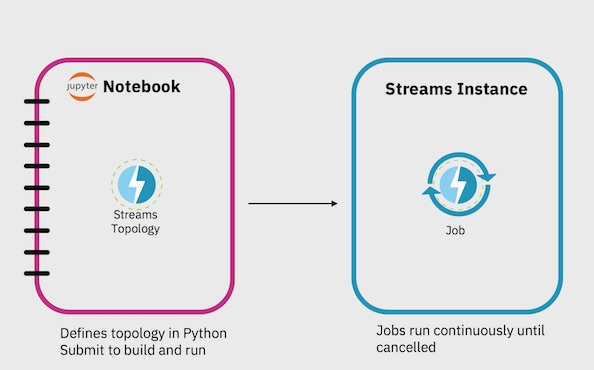


### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)




# Prerequisites

This notebook can be used as-is from within an IBM Cloud Pak for Data project. 

If you are not running this notebook from within IBM Cloud Pak for Data, [follow these steps to make sure you have installed all the prerequisites](https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-2/).

<a name="setup"></a>

# 1. Set up a connection to the Streams instance


To submit the application for execution, you have to connect to the Streams instance. The information required to connect to the instance depends on your development environment and the target installation of Streams. 

Choose the option that matches your development environment.

- **Option 1**: [I'm running the notebook from an IBM Cloud for Data project](#cpd)
- **Option 2**: [I'm using Jupyter Notebooks, Watson Studio/Cloud Pak for Data as a Service, or any other development environment](#notcpd)



<a name="cpd"></a>
### Option 1: Connect to a Streams instance from an IBM Cloud Pak for Data  project

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name
3. Run the cell and skip to section 1.2

The cell below defines a function called `submit_topology` that will be used later on to submit the `Topology` once it is defined.



In [ ]:
from icpd_core import icpd_util
from streamsx.topology import context

streams_instance_name =  "tooling-55-cpd"## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

def submit_topology(topo):
    global cfg
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    # Topology wil be deployed as a distributed app
    contextType = context.ContextTypes.DISTRIBUTED
    return context.submit (contextType, topo, config = cfg)

print("Setup complete, continue to section 1.2")

<a name="notcpd"></a>
### Option 2: Connect to a Streams instance without a Cloud Pak for Data project

*Skip this section if you are running the notebook from a Cloud Pak for Data project.*

The code for each scenario is available in the development guide.  
Each snippet will define a function called `submit_topology` that will be used later to submit the `Topology` once it is defined.

- Choose the tab that best matches your environment. 
- Copy the code under the heading **Copy this code snippet**.
- Paste it in the cell below.

   <a href="https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-2/#connect" target="_blank">Connection instructions from the development guide</a>


### 1.2 Import  the `streamsx` package and verify the package version

In [ ]:
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)

#For more details uncomment line below.
#!pip show streamsx

<a id="create"></a>
# 2. Create the application
 

All Streams applications start with  a `Topology` object, so start by creating one:


In [ ]:
from streamsx.topology.topology import Topology

topo = Topology(name="SensorAverages", namespace="sample")

## 2.1 Define sources
Your application needs some data to analyze, so the first step is to define a data source that produces the data to be analyzed. 

Next, use the data source to create a `Stream` object. A `Stream` is a potentially infinite sequence of **tuples** containing the data to be analyzed.

A tuple can be any Python object.  However, it is recommended to use [NamedTuples](https://docs.python.org/3.6/library/typing.html?highlight=typing#typing.NamedTuple) to describe a tuple's attributes. See below for an example. 

[See the doc for all supported formats](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#stream).

### 2.1.1 Define a source class

The following cell defines the schema for the data to be analyzed, and a callable class that will produce the data.

This example class called `SensorReadingSource` generates a `Stream` of readings from sensors. Each tuple on the `Stream` is an instance of the `SensorReading` class.


In [ ]:
import random 
import time
from datetime import datetime, timedelta

from typing import Iterable, NamedTuple

## Define the schema of the tuples
# each tuple will have a value, sensor id and timestamp
class SensorReading(NamedTuple):
    sensor_id: str
    value: float
    ts: int
        
# Define a callable source 
class SensorReadingsSource(object):
    # function that generates the data
    # notice the type hint is an Iterable of the schema
    def __call__(self) -> Iterable[SensorReading]:
        # This is just an example of using generated data, 
        # Here you could connect to db
        # generate data
        # connect to data set
        # open file
        while True:
            time.sleep(0.001)
            random_id = random.randint(1,100)
            sensor_id = "sensor_" + str(random_id)
            value =  random.random() * 3000
            ts = int((datetime.now().timestamp())) 
            yield SensorReading(sensor_id, value, ts) 

### 2.1.2  Create the `Stream `

Create a `Stream` called  `readings` that will contain the simulated data that `SensorReadingsSource` produces:

In [ ]:
#Create a stream from the data using Topology.source
readings = topo.source(SensorReadingsSource(), name="Readings")

# 2.2 Analyze data

Use a variety of methods in the `Stream` class to analyze your in-flight data, including applying machine learning models.
 
This section will:
- Filter out tuples based on a condition,
- Compute the rolling average, and
- Enrich the rolling average with data from another source.

Built-in methods exist for common operations, such as <code>Stream.filter</code> and <code>Stream.split</code>, which filter or split a stream of data respectively.

See the <a href="/streamsx.documentation/docs/python/1.6/python-appapi-devguide-4/"> common operations section</a> for other common examples. Check out the <a href="https://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#streamsx.topology.topology.Stream">documentation </a> of the <code>Stream</code> class for full list of functions.

### 2.2.1 Filter data from the  `Stream`  

Use `Stream.filter()` to remove data that doesn't match a certain condition. 

In [ ]:
# Accept only values greater than 100

valid_readings = readings.filter(lambda x : x.value > 100,
                                 name="ValidReadings")

# You could create another stream of the invalid data:
# invalid_readings = readings.filter(lambda x : x.value <= 100)

### 2.2.2  Compute averages on the  `Stream`  

Define a function to compute the 30 second rolling average for the readings.

Steps are outlined in the code below.
See the [Window class documentation](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Window)  for details.



In [ ]:
import pandas as pd

# 1. Define schema of aggregation result

class AverageReadings(NamedTuple):
    average: float
    sensor_id: str
    period_end: str
    
# 2. Define aggregation function, note type hint
# this function returns a list of averages
# one for each sensor
def average_reading(items_in_window) -> Iterable[AverageReadings]:
    df = pd.DataFrame(items_in_window)
    readings_by_id = df.groupby("sensor_id")
    
    averages = readings_by_id["value"].mean()
    period_end = df["ts"].max()

    result = []
    for id, avg in averages.iteritems():
        result.append(AverageReadings(avg, id, time.ctime(period_end)))
               
    return result

# 3. Define window: e.g. a 30 second rolling average, updated every second

interval = timedelta(seconds=30)
window = valid_readings.last(size=interval).trigger(when=timedelta(seconds=1))


# 4. Pass aggregation function to Window.aggregate
# average_reading returns a list of the averages for each sensor,
# use flat map to convert it to individual tuples, one per sensor
rolling_average = window.aggregate(average_reading).flat_map()


### 2.2.3 Enrich the data on the `Stream`

Each tuple on the `rolling_average Stream` will have the following format: 

`{'average': 1655.1009278955999, 'sensor_id': 'sensor_17', 'period_end': 'Tue Nov 19 22:07:02 2019'}
`. (See the `average_reading` function above).

Imagine that you want to add the geographical coordinates of the sensor to each tuple. This information might come from a different data source, such as a database.

Use `Stream.map()`. The `map` transform uses a function you provide to convert each tuple on the `Stream` into a new tuple.

In our case, for each tuple on the `rolling_average Stream`,  we will update it to include the geographical coordinates of the sensor. The tuples produced by the `enrich` function will have a new schema, `AverageWithLocation`, which extends the `AverageReadings` schema.


In [ ]:

class AverageWithLocation(NamedTuple):
    average: float
    sensor_id: str
    period_end: str
    latitude: float
    longitude: float

# Modify this tuple with the coordinates of the sensor
# Returns the original tuple with a new coords attribute
# representing the latitude and longitude of the sensor
def enrich(tpl) -> AverageWithLocation:
    # use simulated data, but you could make a database call, 
    latitude = round(random.random() + 39.8338515, 4)
    longitude = round(-74.871826 + random.random(), 4)
    # update the tuple with new data
    enriched_tpl = AverageWithLocation(*tpl, latitude, longitude)
    return enriched_tpl

# Update the data on the rolling_average stream with the map transform
enriched_average = rolling_average.map(enrich, schema=AverageWithLocation)

# 2.3 Create a `View` to preview the tuples on the `Stream` 


A `View` is a connection to a `Stream` that becomes activated when the application is running. The connection allows you to access the data on the `Stream` as it is being processed.


After submitting the `Topology`, we use a `View`  to examine the from within the notebook [in section 4](#view).

To view the data on the `enriched_average Stream`, define a `View` using `Stream.view()`:


In [ ]:
averages_view = enriched_average.view(name="RollingAverage", 
                                      description="Sample of rolling averages for each sensor")


# 2.4 Define output

You have several options for defining the output of your Streams application. 

You could:

 - Print the contents of a `Stream` to the application logs.
 - Enable a microservices based architecture by publishing the contents of a `Stream`. Other Streams applications can connect to the published `Stream`.
 - Send the stream to another database or system.
 - Create a REST service for the Streams application that will make data available via HTTP requests. *(Cloud Pak for Data 3.5+ only)*.

This notebook will:

- Use `Stream.publish()` to make the `enriched_average Stream` available to other applications
- Create a REST endpoint.



In [ ]:
import json
# publish results as JSON
enriched_average.publish(topic="AverageReadings",
                        schema=json, 
                        name="PublishAverage")
# Other options include:
# invoke another sink function:
# rolling_average.for_each(func=send_to_db)
# print the data: enriched_average.print()

<a name="rest"></a>
## 2.5 (Optional)  Create a REST service to access the data

*Skip this step if you are not using Cloud Pak for Data 3.5 or newer*.

In Cloud Pak for Data (CPD) version 3.5+, you can [add a REST endpoint to a Streams application](https://ibm.biz/streams-job-service) so that you can connect to it to retrieve tuples from a `Stream`. 


How does it work?
- First, use `Stream.for_each` to send every tuple on the target `Stream` to an instance of the `EndpointSink` class.
- The [`EndpointSink`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.service.html#streamsx.service.EndpointSink) class creates a new service in the Cloud Pak for Data instance.
-  When the service receives a HTTP `GET` request, it will respond with the tuples on the `Stream`.

To do so,  comment out the following code and run it if you are using CPD 3.5 or newer.



In [ ]:

from streamsx.service import EndpointSink

# send each tuple on the enriched_average stream to the EndpointSink operator
# this operator will create a REST endpoint that you can use to access the data from the stream. 
enriched_average.for_each(EndpointSink(), name="REST Service")

<a name="launch"></a>

# 3. Submit the application

Use this cell to submit the `Topology` for execution, using the `submit_topology` function [defined in step 1](#setup). If the submission is successful, the application will be running on your Streams instance. A running Streams application is called a *job*.  The job ID will be printed below. 

In [ ]:
# The submission_result object contains information about the running application, or job
print("Submitting Topology to Streams for execution..")
submission_result = submit_topology(topo)

if submission_result.job:
    streams_job = submission_result.job
    print ("JobId: ", streams_job.id )
    print ("Job name: %s" % (streams_job.name))

else:
    print("Submission failed: "   + str(submission_result))

<a name="view"></a>

# 4. Use a `View` to access data from the job

Now that the job is started, use the `averages_view` object you created in step 2.3 to start retrieving data from the `enriched_average Stream`.

In [ ]:
print("Fetching view data ...")
# Connect to the view and display the data
queue = averages_view.start_data_fetch()
try:
    for val in range(10):
        print(queue.get(timeout=60))    
finally:
    averages_view.stop_data_fetch()

## 4.1 Display the results in real time
Calling `View.display()` from the notebook displays the results of the view in a table that is updated in real-time.

In [ ]:
# Display the results for 30 seconds
averages_view.display(duration=30)


##  4.2 See application status

The tools available to monitor the running application depend on the version of Streams and your development environment.

- **If you are using a Cloud Pak for Data 3.5 project:**  When you submit the `Topology`, you create a new <i>job run</i>. The job represents the application and the job run represents a single instance of the running application. 

    1. Open your project and click on the **Jobs** tab. This will show a list of the project's jobs.
    1. Under the **Job name** column, find your job based on the `Job Name` [printed in section 3](#launch). This will list all of the job runs for that job.
    1. Click the **Run name** to open the job run. The run name will be the same as the `Job Name` printed above.
    1. This will open the Job Details page.

       1. To open the Job Graph, click the **Streams job graph** link.

       1. To download logs, click the **Logs** tab and click **Create snapshot**, then download the snapshot.  
        

- **For all other development environments and versions of Streams**, [see this page for more information](http://ibmstreams.github.io/streamsx.documentation/docs/spl/quick-start/qs-4).

## 4.3 (Optional) Access the streaming data via REST 
 

If you enabled the REST service in [section 2.5](#rest), you will now have a service in your Cloud Pak for Data instance that you can use to retrieve the data from the application. 

You will need the job id, which was [printed in section 3](#launch) when you submitted the job and the name of the deployment space for your Cloud Pak for Data instance. 

Follow these steps to [find the endpoint and use it](https://community.ibm.com/community/user/cloudpakfordata/communities/community-home/all-news/viewdocument?DocumentKey=7fcd0b55-86fa-4e23-a804-808d3416f902&Step=1&CommunityKey=d55fdf2f-0d75-46ed-8459-afaaa00fc067&ReturnUrl=#find).


<a name="cancel"></a>

# 5. Cancel the job
Streams jobs run indefinitely, so make sure you cancel the job once you are finished running the sample.

In [ ]:
# cancel the job directly using the Job object
submission_result.cancel_job_button()
# or, use
# streams_job.cancel()

# Summary

We started with a `Stream` called `readings`, which contained the data we wanted to analyze. Next, we used functions in the `Stream` object to perform simple analysis and produced the `enriched_average` stream.  This stream is `published` for other applications running within our Streams instance to access.

After submitting the application to the Streams service, we used the `enriched_average` view to see the results.



# Learn more 

Use the links below to learn more.

 - See the documentation for more output options:

    - Print the contents of a `Stream`: [`Stream.print()`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.print),
    - Enable a microservices based architecture: [`Stream.publish`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.publish). Other Streams applications can connect to the published `Stream`.
    - Send the stream to another database or system, using [`Stream.for_each`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.for_each).
    - Create a REST service for the Streams application with the [`EndpointSink` class](https://streamsxtopology.readthedocs.io/en/stable/streamsx.service.html#streamsx.service.EndpointSink)(Cloud Pak for Data v3.5+ only).

- **Find more samples**: This notebook is one of several sample notebooks available in the [starter notebooks repository on GitHub](https://github.com/IBMStreams/sample.starter_notebooks). Visit the repository for examples of how to connect to common data sources, including Apache Kafka, IBM, and Db2 Warehouse. 


- Learn more about how to use the API from the [development guide](http://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide/).